In [46]:
import pandas as pd
pd.set_option('display.max_columns', 60)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
from IPython.core.pylabtools import figsize 

from sklearn.preprocessing import Imputer, StandardScaler

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Загрузка и подготовка данных

In [7]:
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

In [8]:
train_features.head()

,sqrt_Property Id,sqrt_Street Number,sqrt_Year Built,sqrt_Number of Buildings - Self-reported,sqrt_Occupancy,sqrt_Direct GHG Emissions (Metric Tons CO2e),sqrt_Property GFA - Self-Reported (ft²),sqrt_Water Intensity (All Water Sources) (gal/ft²),sqrt_Source EUI (kBtu/ft²),sqrt_Community Board,sqrt_Census Tract,Borough_Bronx,Borough_Brooklyn,Borough_Manhattan,Borough_Queens,Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,Largest Property Use Type_Mailing Center/Post Office,...,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Office,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,1985.077580,NaN,44.564560,1.0,9.746794,12.103718,224.053565,7.410128,10.728467,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1632.546783,34.799425,44.788391,1.0,10.000000,21.156559,409.144229,NaN,10.844353,1.732051,11.180340,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1851.772394,16.911535,43.897608,1.0,10.000000,15.744840,269.486549,NaN,10.271319,3.000000,17.916473,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1842.102060,9.539392,44.631827,1.0,10.000000,25.930677,359.628975,NaN,16.991174,1.000000,5.196152,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,2116.683018,19.824228,43.897608,1.0,10.000000,23.078128,366.309978,NaN,9.132360,2.645751,12.922848,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
train_labels.head()

,score
0,76.0
1,64.0
2,69.0
3,35.0
4,93.0


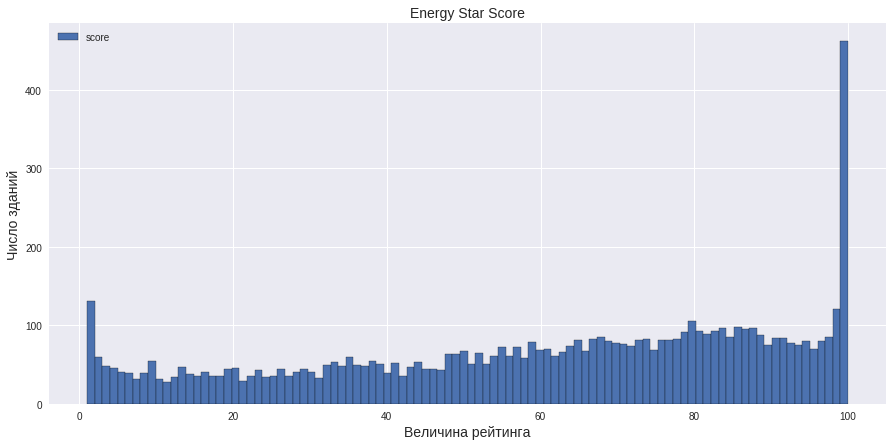

In [24]:
figsize(15, 7)
train_labels.plot(kind = 'hist', bins = 100, edgecolor = 'black')
plt.title('Energy Star Score', fontsize = 14);
plt.ylabel('Число зданий', fontsize = 14);
plt.xlabel('Величина рейтинга', fontsize = 14);

Заполним пропущенные значения в данных

In [36]:
imputer = Imputer(strategy = 'median')
imputer.fit(train_features)

X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

print('Число пропущенных значений в тренировочной выборке: {}'.format(np.sum(np.isnan(X))))
print('Число пропущенных значений в тестовой выборке: {}'.format(np.sum(np.isnan(X_test))))
print()
print('Число inf значений в тренировочной выборке: {}'.format(np.sum(np.where(~np.isfinite(X)))))
print('Число inf значений в тестовой выборке: {}'.format(np.sum(np.where(~np.isfinite(X_test)))))

Число пропущенных значений в тренировочной выборке: 0
Число пропущенных значений в тестовой выборке: 0

Число inf значений в тренировочной выборке: 0
Число inf значений в тестовой выборке: 0


Масштабируем признаки

In [38]:
scaler = StandardScaler()
scaler.fit(train_features)

X = scaler.transform(train_features)
X_test = scaler.transform(test_features)

/home/grigoriy/anaconda3/envs/basic_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/grigoriy/anaconda3/envs/basic_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/home/grigoriy/anaconda3/envs/basic_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [44]:
y = np.array(train_labels).reshape(-1) #get 1-D array
y_test = np.array(test_labels).reshape(-1)

## Подбор модели

In [45]:
def get_MAE(y_test, y_pred):
    return np.mean(abs(y_test - y_pred))

def fit_and_evaluate(model):
    model.fit(X, y)
    model_mae = get_MAE(y_test, predict(X_test))
    return model_mae

Проведем грубый решетчатый поиск 

In [ ]:
models_dict = {
    'Lasso regression': Lasso(random_state=42),
    'Random Forest regression': RandomForestRegressor(random_state = 42),
    'Gradient Boosting regression': GradientBoostingRegressor(random_state=42),
    'SVM regression': SVR(random_state=42),
    'KNN regression': KNeighborsRegressor(random_state = 42)
    }

In [ ]:
parameters_grid_dict = {
    'Lasso regression': {'alpha': np.linspace(0, 1, 10)}
    'Random Forest regression': {'n_estimators': np.arange(100, 1000, 10)}
}

In [47]:

# from sklearn.linear_model import Lasso
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.svm import SVR
# from sklearn.neighbors import KNeighborsRegressor

# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV